# Demonic Dealings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

from numba import njit          # Import this if you're using @njit to speed up your code

In [2]:
@njit
def oneMCS(v, systemEnergy, demonEnergy):
    '''
    Perform one Monte-Carlo "sweep", with the demon running over all the particles once
    and trying to change each particle's velocity.

    Parameters:
    -----------
    • v            : An array of `N` elements storing the velocity of each particle at the start of this sweep.
    • systemEnergy : A number containing the energy of the system at the start of this sweep.
    • demonEnergy  : A number containing the energy of the demon at the start of this sweep.
   
    Returns:
    --------
    The function returns three values:
    • v            : An array of `N` elements storing the velocity of each particle at the end of this sweep.
    • systemEnergy : A number containing the energy of the system at the end of this sweep.
    • demonEnergy  : A number containing the energy of the demon at the end of this sweep.
   
    '''

    ## The lines that follow implement the algorithm given in the assignment.
    
    maxdv = 2                                     # Choose a maximum velocity change
    
    for i in range(N):                            # Run a loop N times
        p = np.random.randint(N)                  # Choose a particle at random
        
        dv = (2*np.random.uniform(0,1)-1)*maxdv   # Choose a random speed between `-maxdv` and `+maxdv`

        trial_v = v[p]+dv                         # Define a "trial" velocity which might be accepted

        dE = 0.5*(trial_v**2 - v[p]**2)           # Compute the change in energy due to the trial velocity

        if(dE<=demonEnergy):                      # If the demon has enough energy to give (including case dE<0)
            v[p] = trial_v                        # Change the particle's velocity to the trial velocity
            systemEnergy += dE                    # Change the system's energy
            demonEnergy -= dE                     # Change the demon's energy

    return v, systemEnergy, demonEnergy

In [3]:
def simulate(N, E, n_mcsweeps = 10_000):
    '''
    Perform a simulation of `n_mcsweeps` Monte-Carlo sweeps.

    Parameters:
    -----------
    • N           : The number of particles of our gas.
    • E           : The total energy of the system.
    • n_mcsweeps  : Number of Monte-Carlo sweeps to perform.
   
    Returns:
    --------
    The function returns two values:
    • systemEnergyArray : An array containing the energy of the system at each MC sweep.
    • demonEnergyArray  : An array containing the energy of the demon at each MC sweep.
   
    '''

    v0 = np.sqrt(2*E/N)                        # Set the uniform initial particle velocity, v0 as function of E and N
    v = np.ones(N)*v0

    demonEnergyArray  = np.zeros(n_mcsweeps)   # Arrays to store the demon and 
    systemEnergyArray = np.zeros(n_mcsweeps)   # system energies
    
    demonEnergyArray[0]  = 0                   # Set the initial demon energy
    systemEnergyArray[0] = np.sum(v**2)/2      # Set the initial system energy

    for mc in range(1,n_mcsweeps):
        v, systemEnergyArray[mc], demonEnergyArray[mc] = oneMCS(demonEnergy=demonEnergyArray[mc-1], systemEnergy=systemEnergyArray[mc-1], v=v)

    return systemEnergyArray, demonEnergyArray

In [4]:
%%time
# This is a magic Jupyter command that times a cell. 
# It should take ~ 15 s without using Numba, and ~ 200 ms with it
N=100
system1, demon1 = simulate(N=N, E=15)
system2, demon2 = simulate(N=N, E=25)

CPU times: user 495 ms, sys: 107 ms, total: 602 ms
Wall time: 546 ms


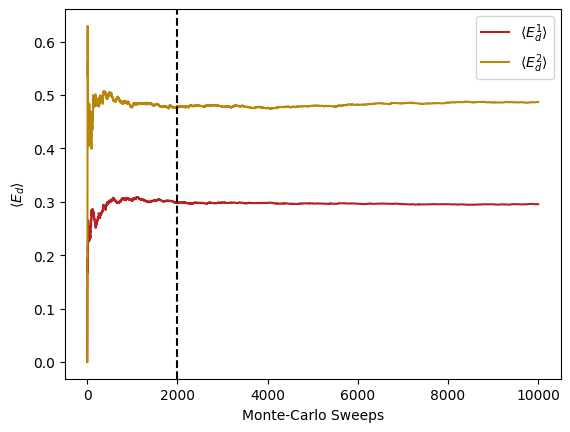

In [5]:
average_Ed1_over_mcs = np.cumsum(demon1)/np.arange(1,len(demon1)+1) # Compute the average demon energy over
average_Ed2_over_mcs = np.cumsum(demon2)/np.arange(1,len(demon2)+1) # multiple MC sweeps for each case

plt.plot(average_Ed1_over_mcs, label=r"$\langle E_d^{1}\rangle$", color='firebrick')
plt.plot(average_Ed2_over_mcs, label=r"$\langle E_d^{2}\rangle$", color='darkgoldenrod')
plt.ylabel(r"$\langle E_d\rangle$")
plt.xlabel(r"Monte-Carlo Sweeps")

plt.axvline(2000, color='k', ls='--')
plt.legend()
plt.show()

In [6]:
cutoff1 = 2000 # A cutoff of around 1000 MC sweeps works for both cases. After this value,
cutoff2 = 2000 # the average energy over multiple MC sweeps is stable.

mean_Es1_pp = np.mean(system1[-cutoff1:])/N        # The last `cutoff1` values are averaged per particle
mean_Ed1    = np.mean(demon1[-cutoff1:])           # The average demon energy is computed as well

mean_Es2_pp = np.mean(system2[-cutoff2:])/N
mean_Ed2    = np.mean(demon2[-cutoff2:])

print("Mean system energy per particle:",mean_Es1_pp," Mean demon energy", mean_Ed1, ". Ratio =",mean_Es1_pp/mean_Ed1)
print("Mean system energy per particle:",mean_Es2_pp," Mean demon energy", mean_Ed2, ". Ratio =",mean_Es2_pp/mean_Ed2)

Mean system energy per particle: 0.14703843801064365  Mean demon energy 0.29615619893577805 . Ratio = 0.49648948270884974
Mean system energy per particle: 0.24508784411265136  Mean demon energy 0.4912155887351203 . Ratio = 0.498941502943244


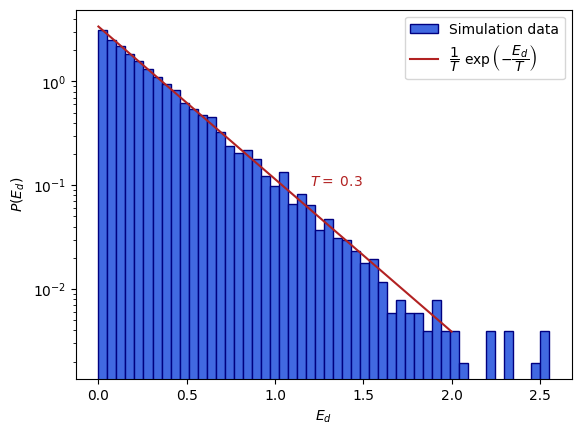

In [7]:
plt.hist(demon1, bins=50, density=True, color='royalblue', ec='navy', label="Simulation data");
plt.yscale('log')
Ed = np.linspace(0,2,100)
plt.plot(Ed,(1/np.mean(demon1))*np.exp(-Ed/np.mean(demon1)), color='firebrick', label=r"$\dfrac{1}{T} \,\,\exp\left(-\dfrac{E_d}{T}\right)$")
plt.ylabel(r"$P(E_d)$")
plt.xlabel(r"$E_d$")

plt.text(1.2, 0.1,r"$T =$ "+str(round(np.mean(demon1),2)), color='firebrick')
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
<b>Comment:</b> In the above cell it is clear that the probability of the system being in a specific microstate with energy $E_d$ follows the Boltzman distribution. This is clearly seen when we plot the $y-$axis in a log scale. The resulting distribution is linear in this scale, the slope of which should be equal to the systems "temperature".
    
The temperature parameter of this distribution is found to be the average demon energy, meaning that the demon can be used as a "thermometer".
</div>

In [8]:
def simDd(N,E, D=1, n_mcsteps = 50000):   # Generalising our algorithm to D dimensions

    v0 = np.sqrt(2*E/N/D)                 # All particles initially have the same energy
    v = np.ones((N, D))*v0                # All _components_ of the initial velocity are v0

    mcs = 0                               # Count of number of mcs completed
    demonEnergy = 0                       # Demon's initial energy
    systemEnergy = np.sum(v**2)/2         # System's initial energy
    n_accepted = 0                        # Count of number of accepted changes

    maxdv = 2                             # Maximum velocity change allowed per component

    @njit
    def oneMC(demonEnergy, systemEnergy, n_accepted, mcs, v): # Some new parameters imported because of numba constraints

        for i in range(N):                                    # This follows the same basic idea, generalised to D-dim
            p = np.random.randint(N)

            dv = np.zeros(D)                                  # dv is now a D-di velocity array
            for i in range(D):                                # with random entries between (-maxdv,+maxdv)
                dv[i] = (2*np.random.uniform(0,1)-1)*maxdv

            trial_v = v[p]+dv

            dE = np.sum(0.5*(trial_v**2 - v[p]**2))           # The sum makes sure we compute the norm
                        
            if(dE<=demonEnergy):                              # The rest of this section is identical to the 1d case
                v[p] = trial_v
                n_accepted += 1
                systemEnergy += dE
                demonEnergy -= dE

        mcs += 1
        return demonEnergy, systemEnergy, n_accepted, mcs, v
    
    demon = np.zeros(n_mcsteps)
    system= np.zeros(n_mcsteps)

    for mc in range(n_mcsteps):
        demonEnergy, systemEnergy, n_accepted, mcs, v = oneMC(demonEnergy, systemEnergy, n_accepted, mcs,v)
        demon[mc], system[mc] = demonEnergy, systemEnergy
        
    return np.mean(system[-n_mcsteps//2:])/N, np.mean(demon[-n_mcsteps//2:]), demon   # The last n_mcsteps/2 results are averaged

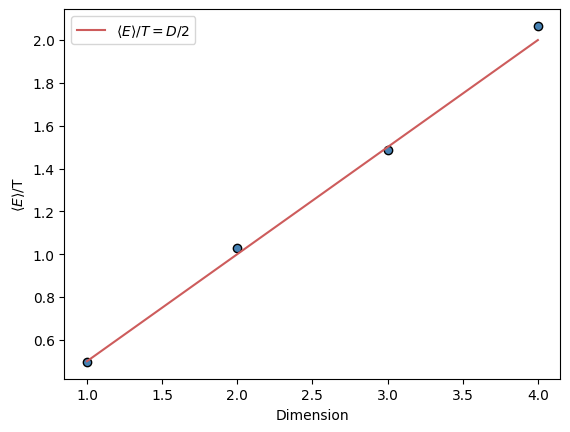

CPU times: user 2.2 s, sys: 20.3 ms, total: 2.22 s
Wall time: 2.25 s


In [9]:
%%time
N=100                  # Number of particles
E = 15                 # Initial energy
Ds = np.arange(1,5)    # Dimensions of space (1 to 5 dimensions, even though it's unphysical!)
n_mcsteps =10_000      # Number of MC sweeps

mean_system_energies = np.zeros_like(Ds, dtype=np.float64) # Arrays to store system energies and temperatures
mean_demon_energy    = np.zeros_like(Ds, dtype=np.float64)

for d in range(len(Ds)):
    msys, mdem, demon = simDd(N=N,E=E,D=Ds[d],n_mcsteps=n_mcsteps) # Simulate system for different dimensions
    mean_system_energies[d] = msys # Store the mean system energy
    mean_demon_energy[d] = mdem    # and the mean demon energy (i.e., the temperature)

plt.scatter(Ds, mean_system_energies/mean_demon_energy, color='steelblue', ec='k') # Plot the ratio of the two as a function of dimension
plt.plot(Ds, 0.5*Ds, color='indianred', label=r"$\langle E \rangle/T = D/2$")      # Plot the result from equipartition theorem
plt.ylabel(r"$\langle E \rangle$/T")
plt.xlabel("Dimension")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
<b>Comment:</b> By simulating the system in different spatial dimensions, we see that the ratio of the mean system energy and the mean demon energy (i.e., the temperature) scales up linearly with dimension, with a slope of 1/2. This is exactly what is predicted by the principle of equipartition of energy, which states that the mean system energy has a contribution of (1/2)T from each quadratic degree of freedom. For a $D-$dimensional classical ideal gas, this is equivalent to saying that \begin{equation} \langle E \rangle = \frac{1}{2} D T, \end{equation} as we have shown in the above plot.
</div>